In [7]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms.minimum_eigen_solvers import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP

In [17]:
from qiskit.chemistry import FermionicOperator


fo = FermionicOperator(h1=h1, h2=h2)

mapping = fo.mapping("parity")

print(mapping)


AttributeError: 'list' object has no attribute 'shape'

In [8]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


In [9]:
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimization complete      


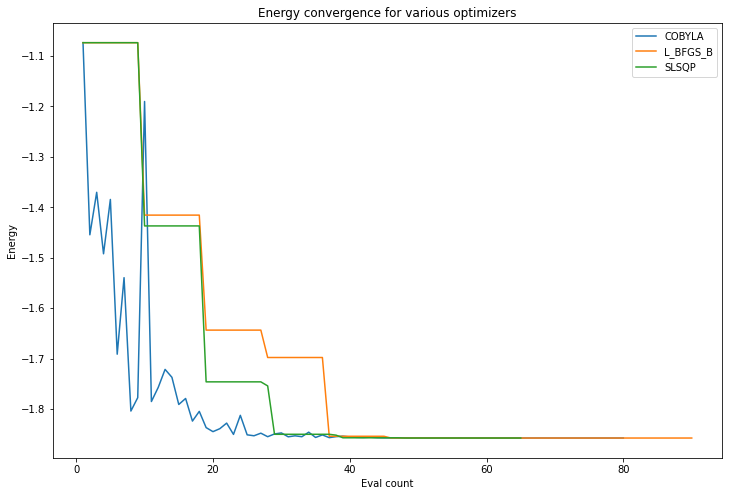

In [10]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

Next we can compute a reference value for easy problems

In [11]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


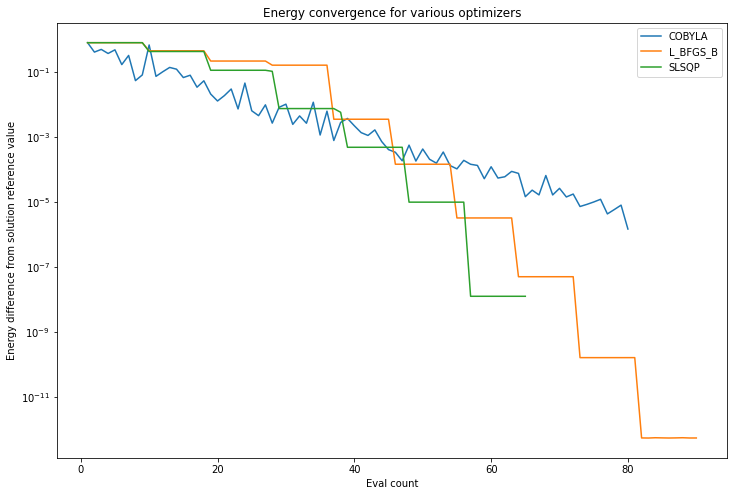

In [12]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');

Next we can compute a reference value for eac